In [539]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import optuna
from math import floor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
pd.options.display.max_rows = 4000

In [540]:
df = pd.read_csv('./canadian-hospital-re-admittance-challenge/train.csv')
test_df = pd.read_csv('./canadian-hospital-re-admittance-challenge/test.csv')
df

,enc_id,patient_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmission_id
0,88346340,2488608,Caucasian,Male,[60-70),NaN,1,2,6,3,...,No,Steady,No,No,No,No,No,Ch,Yes,2
1,92001408,52133202,Caucasian,Male,[70-80),[100-125),2,6,1,7,...,No,No,No,No,No,No,No,No,Yes,1
2,169424316,40945509,Caucasian,Female,[70-80),NaN,3,2,1,7,...,No,Up,No,No,No,No,No,Ch,Yes,1
3,272987082,38850777,Caucasian,Female,[50-60),NaN,1,1,7,1,...,No,No,No,No,No,No,No,No,Yes,2
4,150600612,72738225,Caucasian,Female,[80-90),NaN,1,6,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71231,198619164,85063725,Caucasian,Male,[70-80),NaN,1,1,7,6,...,No,No,No,No,No,No,No,No,Yes,1
71232,177404100,86244345,Caucasian,Male,[90-100),NaN,1,3,7,5,...,No,No,No,No,No,No,No,No,No,2
71233,50905206,5131368,Caucasian,Male,[70-80),NaN,3,6,1,6,...,No,Steady,No,No,No,No,No,Ch,Yes,2
71234,216431502,85969035,Hispanic,Male,[50-60),NaN,1,1,4,4,...,No,Steady,No,No,No,No,No,No,Yes,2


In [541]:
percent_missing = df.isnull().sum() * 100 / len(df)

percentages_df = pd.DataFrame({
    'percent_missing': percent_missing
})

percentages_df

,percent_missing
enc_id,0.000000
patient_id,0.000000
race,2.275535
gender,0.000000
age,0.000000
weight,96.841485
admission_type_id,0.000000
discharge_disposition_id,0.000000
admission_source_id,0.000000
time_in_hospital,0.000000


In [542]:
max_glu_serum_group = df.groupby(by=['max_glu_serum'])
max_glu_serum_group.count()['enc_id']

max_glu_serum
>200    1034
>300     897
Norm    1790
Name: enc_id, dtype: int64

In [543]:
a1c_result_group = df.groupby(by=['A1Cresult'])
a1c_result_group.count()['enc_id']

A1Cresult
>7      2689
>8      5715
Norm    3476
Name: enc_id, dtype: int64

In [544]:
specialty_group = df.groupby(by=['medical_specialty'])
specialty_group.count()['enc_id']

medical_specialty
AllergyandImmunology                        6
Anesthesiology                              9
Anesthesiology-Pediatric                   15
Cardiology                               3820
Cardiology-Pediatric                        6
DCPTEAM                                     3
Dentistry                                   4
Dermatology                                 1
Emergency/Trauma                         5305
Endocrinology                              88
Endocrinology-Metabolism                    6
Family/GeneralPractice                   5180
Gastroenterology                          391
Gynecology                                 44
Hematology                                 53
Hematology/Oncology                       151
Hospitalist                                34
InfectiousDiseases                         26
InternalMedicine                        10183
Nephrology                               1156
Neurology                                 143
Neurophysiology 

In [545]:
race_group = df.groupby(by=['race'])
race_group.count()['enc_id']

race
AfricanAmerican    13351
Asian                432
Caucasian          53373
Hispanic            1428
Other               1031
Name: enc_id, dtype: int64

In [546]:
df["max_glu_serum"].fillna("Norm", inplace = True)
df["A1Cresult"].fillna("Norm",inplace=True)
df["medical_specialty"].fillna("No-Admitting-Physician", inplace=True)
df["race"].fillna("Other", inplace=True)

test_df["max_glu_serum"].fillna("Norm", inplace = True)
test_df["A1Cresult"].fillna("Norm",inplace=True)
test_df["medical_specialty"].fillna("No-Admitting-Physician", inplace=True)
test_df["race"].fillna("Other", inplace=True)

In [547]:
df.drop(columns=['enc_id','patient_id','weight','payer_code','medical_specialty', 'max_glu_serum', 'A1Cresult'],inplace=True)
test_df.drop(columns=['enc_id','patient_id','weight','payer_code','medical_specialty', 'max_glu_serum', 'A1Cresult'],inplace=True)

In [548]:
percent_missing = df.isnull().sum() * 100 / len(df)

percentages_df = pd.DataFrame({
    'percent_missing': percent_missing
})

percentages_df

,percent_missing
race,0.000000
gender,0.000000
age,0.000000
admission_type_id,0.000000
discharge_disposition_id,0.000000
admission_source_id,0.000000
time_in_hospital,0.000000
num_lab_procedures,0.000000
num_procedures,0.000000
num_medications,0.000000


In [549]:
# df.loc[df['diag_1'].notnull(), 'diag_1'] = 4
# df.loc[df['diag_2'].notnull(), 'diag_2'] = 2
# df.loc[df['diag_3'].notnull(), 'diag_3'] = 1

# df['diag_1'].fillna(0,inplace=True)
# df['diag_2'].fillna(0,inplace=True)
# df['diag_3'].fillna(0,inplace=True)

# test_df.loc[test_df['diag_1'].notnull(), 'diag_1'] = 4
# test_df.loc[test_df['diag_2'].notnull(), 'diag_2'] = 2
# test_df.loc[test_df['diag_3'].notnull(), 'diag_3'] = 1

# test_df['diag_1'].fillna(0,inplace=True)
# test_df['diag_2'].fillna(0,inplace=True)
# test_df['diag_3'].fillna(0,inplace=True)

# df.loc[:,'diag_1':'diag_3']

diag_grouping_dict = {
    0 : [0],
    1 : range(1,140),
    2 : range(140,240),
    3 : range(240,280),
    4 : range(280,290),
    5 : range(290,320), 
    6 : range(320,390),
    7 : range(390,460),
    8 : range(460,520),
    9 : range(520,580),
    10: range(580,630),
    11: range(630,680),
    12: range(680,710),
    13: range(710,740),
    14: range(740,760),
    15: range(760-780),
    16: range(780,800),
    17: range(800,1000)
}

def diag_convert1(row):
    if str(row['diag_1'])[0] in ['E','V']:
        return 18
    else:
        for j in diag_grouping_dict.keys():
            if floor(float(row['diag_1'])) in diag_grouping_dict[j]:
                return j


def diag_convert2(row):
    if str(row['diag_2'])[0] in ['E','V']:
        return 18
    else:
        for j in diag_grouping_dict.keys():
            if floor(float(row['diag_2'])) in diag_grouping_dict[j]:
                return j
            

def diag_convert3(row):
    if str(row['diag_3'])[0] in ['E','V']:
        return 18
    else:
        for j in diag_grouping_dict.keys():
            if floor(float(row['diag_3'])) in diag_grouping_dict[j]:
                return j


In [550]:
df.fillna("0", inplace=True)
test_df.fillna("0", inplace=True)

new_col = df.apply(diag_convert1, axis=1)
df.insert(loc = len(df.columns)-1, column = 'diag_1_new', value=new_col)
df.drop(columns=['diag_1'], inplace=True)

new_col = test_df.apply(diag_convert1, axis=1)
test_df.insert(loc = len(test_df.columns), column = 'diag_1_new', value=new_col)
test_df.drop(columns=['diag_1'], inplace=True)

new_col = df.apply(diag_convert2, axis=1)
df.insert(loc = len(df.columns)-1, column = 'diag_2_new', value=new_col)
df.drop(columns=['diag_2'], inplace=True)

new_col = test_df.apply(diag_convert2, axis=1)
test_df.insert(loc = len(test_df.columns), column = 'diag_2_new', value=new_col)
test_df.drop(columns=['diag_2'], inplace=True)

new_col = df.apply(diag_convert3, axis=1)
df.insert(loc = len(df.columns)-1, column = 'diag_3_new', value=new_col)
df.drop(columns=['diag_3'], inplace=True)

new_col = test_df.apply(diag_convert3, axis=1)
test_df.insert(loc = len(test_df.columns), column = 'diag_3_new', value=new_col)
test_df.drop(columns=['diag_3'], inplace=True)

In [551]:
diag3_group = df.groupby(by=['diag_3_new'])
diag3_group.count()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,diag_1_new,diag_2_new,readmission_id
diag_3_new,,,,,,,,,,,,,,,,,,,,,
0,989,989,989,989,989,989,989,989,989,989,...,989,989,989,989,989,989,989,989,989,989
1,1277,1277,1277,1277,1277,1277,1277,1277,1277,1277,...,1277,1277,1277,1277,1277,1277,1277,1277,1277,1277
2,1320,1320,1320,1320,1320,1320,1320,1320,1320,1320,...,1320,1320,1320,1320,1320,1320,1320,1320,1320,1320
3,18430,18430,18430,18430,18430,18430,18430,18430,18430,18430,...,18430,18430,18430,18430,18430,18430,18430,18430,18430,18430
4,1731,1731,1731,1731,1731,1731,1731,1731,1731,1731,...,1731,1731,1731,1731,1731,1731,1731,1731,1731,1731
5,2217,2217,2217,2217,2217,2217,2217,2217,2217,2217,...,2217,2217,2217,2217,2217,2217,2217,2217,2217,2217
6,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218,...,1218,1218,1218,1218,1218,1218,1218,1218,1218,1218
7,20939,20939,20939,20939,20939,20939,20939,20939,20939,20939,...,20939,20939,20939,20939,20939,20939,20939,20939,20939,20939
8,4732,4732,4732,4732,4732,4732,4732,4732,4732,4732,...,4732,4732,4732,4732,4732,4732,4732,4732,4732,4732


In [552]:
diag1_group = df.groupby(by=['diag_1_new'])
diag1_group.count()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,diag_2_new,diag_3_new,readmission_id
diag_1_new,,,,,,,,,,,,,,,,,,,,,
0,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1,1934,1934,1934,1934,1934,1934,1934,1934,1934,1934,...,1934,1934,1934,1934,1934,1934,1934,1934,1934,1934
2,2428,2428,2428,2428,2428,2428,2428,2428,2428,2428,...,2428,2428,2428,2428,2428,2428,2428,2428,2428,2428
3,7959,7959,7959,7959,7959,7959,7959,7959,7959,7959,...,7959,7959,7959,7959,7959,7959,7959,7959,7959,7959
4,797,797,797,797,797,797,797,797,797,797,...,797,797,797,797,797,797,797,797,797,797
5,1584,1584,1584,1584,1584,1584,1584,1584,1584,1584,...,1584,1584,1584,1584,1584,1584,1584,1584,1584,1584
6,839,839,839,839,839,839,839,839,839,839,...,839,839,839,839,839,839,839,839,839,839
7,21346,21346,21346,21346,21346,21346,21346,21346,21346,21346,...,21346,21346,21346,21346,21346,21346,21346,21346,21346,21346
8,7280,7280,7280,7280,7280,7280,7280,7280,7280,7280,...,7280,7280,7280,7280,7280,7280,7280,7280,7280,7280


In [553]:
diag2_group = df.groupby(by=['diag_2_new'])
diag2_group.count()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,diag_1_new,diag_3_new,readmission_id
diag_2_new,,,,,,,,,,,,,,,,,,,,,
0,244,244,244,244,244,244,244,244,244,244,...,244,244,244,244,244,244,244,244,244,244
1,1333,1333,1333,1333,1333,1333,1333,1333,1333,1333,...,1333,1333,1333,1333,1333,1333,1333,1333,1333,1333
2,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,...,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821
3,14675,14675,14675,14675,14675,14675,14675,14675,14675,14675,...,14675,14675,14675,14675,14675,14675,14675,14675,14675,14675
4,2078,2078,2078,2078,2078,2078,2078,2078,2078,2078,...,2078,2078,2078,2078,2078,2078,2078,2078,2078,2078
5,1876,1876,1876,1876,1876,1876,1876,1876,1876,1876,...,1876,1876,1876,1876,1876,1876,1876,1876,1876,1876
6,913,913,913,913,913,913,913,913,913,913,...,913,913,913,913,913,913,913,913,913,913
7,21951,21951,21951,21951,21951,21951,21951,21951,21951,21951,...,21951,21951,21951,21951,21951,21951,21951,21951,21951,21951
8,7176,7176,7176,7176,7176,7176,7176,7176,7176,7176,...,7176,7176,7176,7176,7176,7176,7176,7176,7176,7176


In [554]:
# new_col = df['diag_1']+df['diag_2']+df['diag_3']
# df.insert(loc = len(df.columns)-1, column = 'Number_of_Diagnosis', value=new_col)

# new_col = test_df['diag_1']+test_df['diag_2']+test_df['diag_3']
# test_df.insert(loc = len(test_df.columns), column = 'Number_of_Diagnosis', value=new_col)


In [555]:
# diag_groups = df.groupby(by=['Number_of_Diagnosis'])
# diag_groups.count()

In [556]:
# df.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)
# test_df.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)

In [557]:
# admission_grouping_dict = {
#     1 : [1],
#     2 : [2],
#     3 : [3],
#     4 : [4],
#     5 : [5,6,8], 
#     6 : [7]
# }

# def admission_group(row):
#     for j in admission_grouping_dict.keys():
#         if row['admission_type_id'] in admission_grouping_dict[j]:
#             return j

# new_col = df.apply(admission_group, axis=1)
# df.insert(loc = len(df.columns)-1, column = 'admission_type_id_new', value=new_col)
# df.drop(columns=['admission_type_id'], inplace=True)

# new_col = test_df.apply(admission_group, axis=1)
# test_df.insert(loc = len(test_df.columns), column = 'admission_type_id_new', value=new_col)
# test_df.drop(columns=['admission_type_id'], inplace=True)

# temp_df = df.groupby(by=['admission_type_id_new'])
# temp_df.count()

In [558]:
# discharge_grouping_dict = {
#     1 : [11,19,20,21],
#     2 : [18,25,26],
#     3 : [7],
#     4 : [1,6,8,13,14],
#     5 : [2,3,4,5,10,16,22,23,24,30,27,28,29],
#     6 : [9,12,15,17]
# }

# def discharge_group(row):
#     for j in discharge_grouping_dict.keys():
#         if row['discharge_disposition_id'] in discharge_grouping_dict[j]:
#             return j
        
# new_col = df.apply(discharge_group, axis=1)
# df.insert(loc = len(df.columns)-1, column = 'discharge_type_id_new', value=new_col)
# df.drop(columns=['discharge_disposition_id'], inplace=True)

# new_col = test_df.apply(discharge_group, axis=1)
# test_df.insert(loc = len(test_df.columns), column = 'discharge_type_id_new', value=new_col)
# test_df.drop(columns=['discharge_disposition_id'], inplace=True)

# temp_df = df.groupby(by=['discharge_type_id_new'])
# temp_df.count()

In [559]:
# source_grouping_dict = {
#     1 : [4,5,6,10,18,22,25,26],
#     2 : [1,2,3],
#     3 : [11,12,13,14],
#     4 : [9,15,17,20,21],
#     5 : [7],
#     6 : [8]
# }

# def source_group(row):
#     for j in source_grouping_dict.keys():
#         if row['admission_source_id'] in source_grouping_dict[j]:
#             return j

# new_col = df.apply(source_group, axis=1)
# df.insert(loc = len(df.columns)-1, column = 'admission_source_id_new', value=new_col)
# df.drop(columns=['admission_source_id'], inplace=True)

# new_col = test_df.apply(source_group, axis=1)
# test_df.insert(loc = len(test_df.columns), column = 'admission_source_id_new', value=new_col)
# test_df.drop(columns=['admission_source_id'], inplace=True)

# temp_df = df.groupby(by=['admission_source_id_new'])
# temp_df.count()

In [560]:
for col in df.loc[:,'metformin':'diabetesMed']:
    med_groups = df.groupby(by=[col])
    print(med_groups.count().iloc[:, 0])

metformin
Down        392
No        57223
Steady    12885
Up          736
Name: race, dtype: int64
repaglinide
Down         33
No        70145
Steady      980
Up           78
Name: race, dtype: int64
nateglinide
Down          8
No        70770
Steady      444
Up           14
Name: race, dtype: int64
chlorpropamide
No        71170
Steady       62
Up            4
Name: race, dtype: int64
glimepiride
Down        131
No        67558
Steady     3308
Up          239
Name: race, dtype: int64
acetohexamide
No        71235
Steady        1
Name: race, dtype: int64
glipizide
Down        376
No        62301
Steady     8011
Up          548
Name: race, dtype: int64
glyburide
Down        389
No        63713
Steady     6577
Up          557
Name: race, dtype: int64
tolbutamide
No        71221
Steady       15
Name: race, dtype: int64
pioglitazone
Down         83
No        66074
Steady     4910
Up          169
Name: race, dtype: int64
rosiglitazone
Down         67
No        66740
Steady     4303
Up      

In [561]:
df.drop(columns=['chlorpropamide', 'tolbutamide', 'miglitol', 'acarbose', 'tolazamide', 'acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'glyburide-metformin'], inplace=True)
test_df.drop(columns=['chlorpropamide', 'tolbutamide', 'miglitol', 'acarbose', 'tolazamide', 'acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'glyburide-metformin'], inplace=True)
df.columns.size

29

In [562]:
def count_changes(row):
    count =0
    for col in ['metformin','repaglinide','nateglinide','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','insulin']:
        if(row[col]=='Up' or row[col]=='Down'):
            count+=1
    if(row['change']=='change'):count+=1
    return count

new_col = df.apply(count_changes, axis=1)
df.insert(loc = len(df.columns)-1, column = 'changes', value=new_col)

new_col = test_df.apply(count_changes, axis=1)
test_df.insert(loc = len(test_df.columns), column = 'changes', value=new_col)


In [563]:
df.drop(columns=['metformin','repaglinide','nateglinide','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','insulin','change'], inplace=True)
test_df.drop(columns=['metformin','repaglinide','nateglinide','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','insulin','change'], inplace=True)
df.columns.size

20

<Axes: >

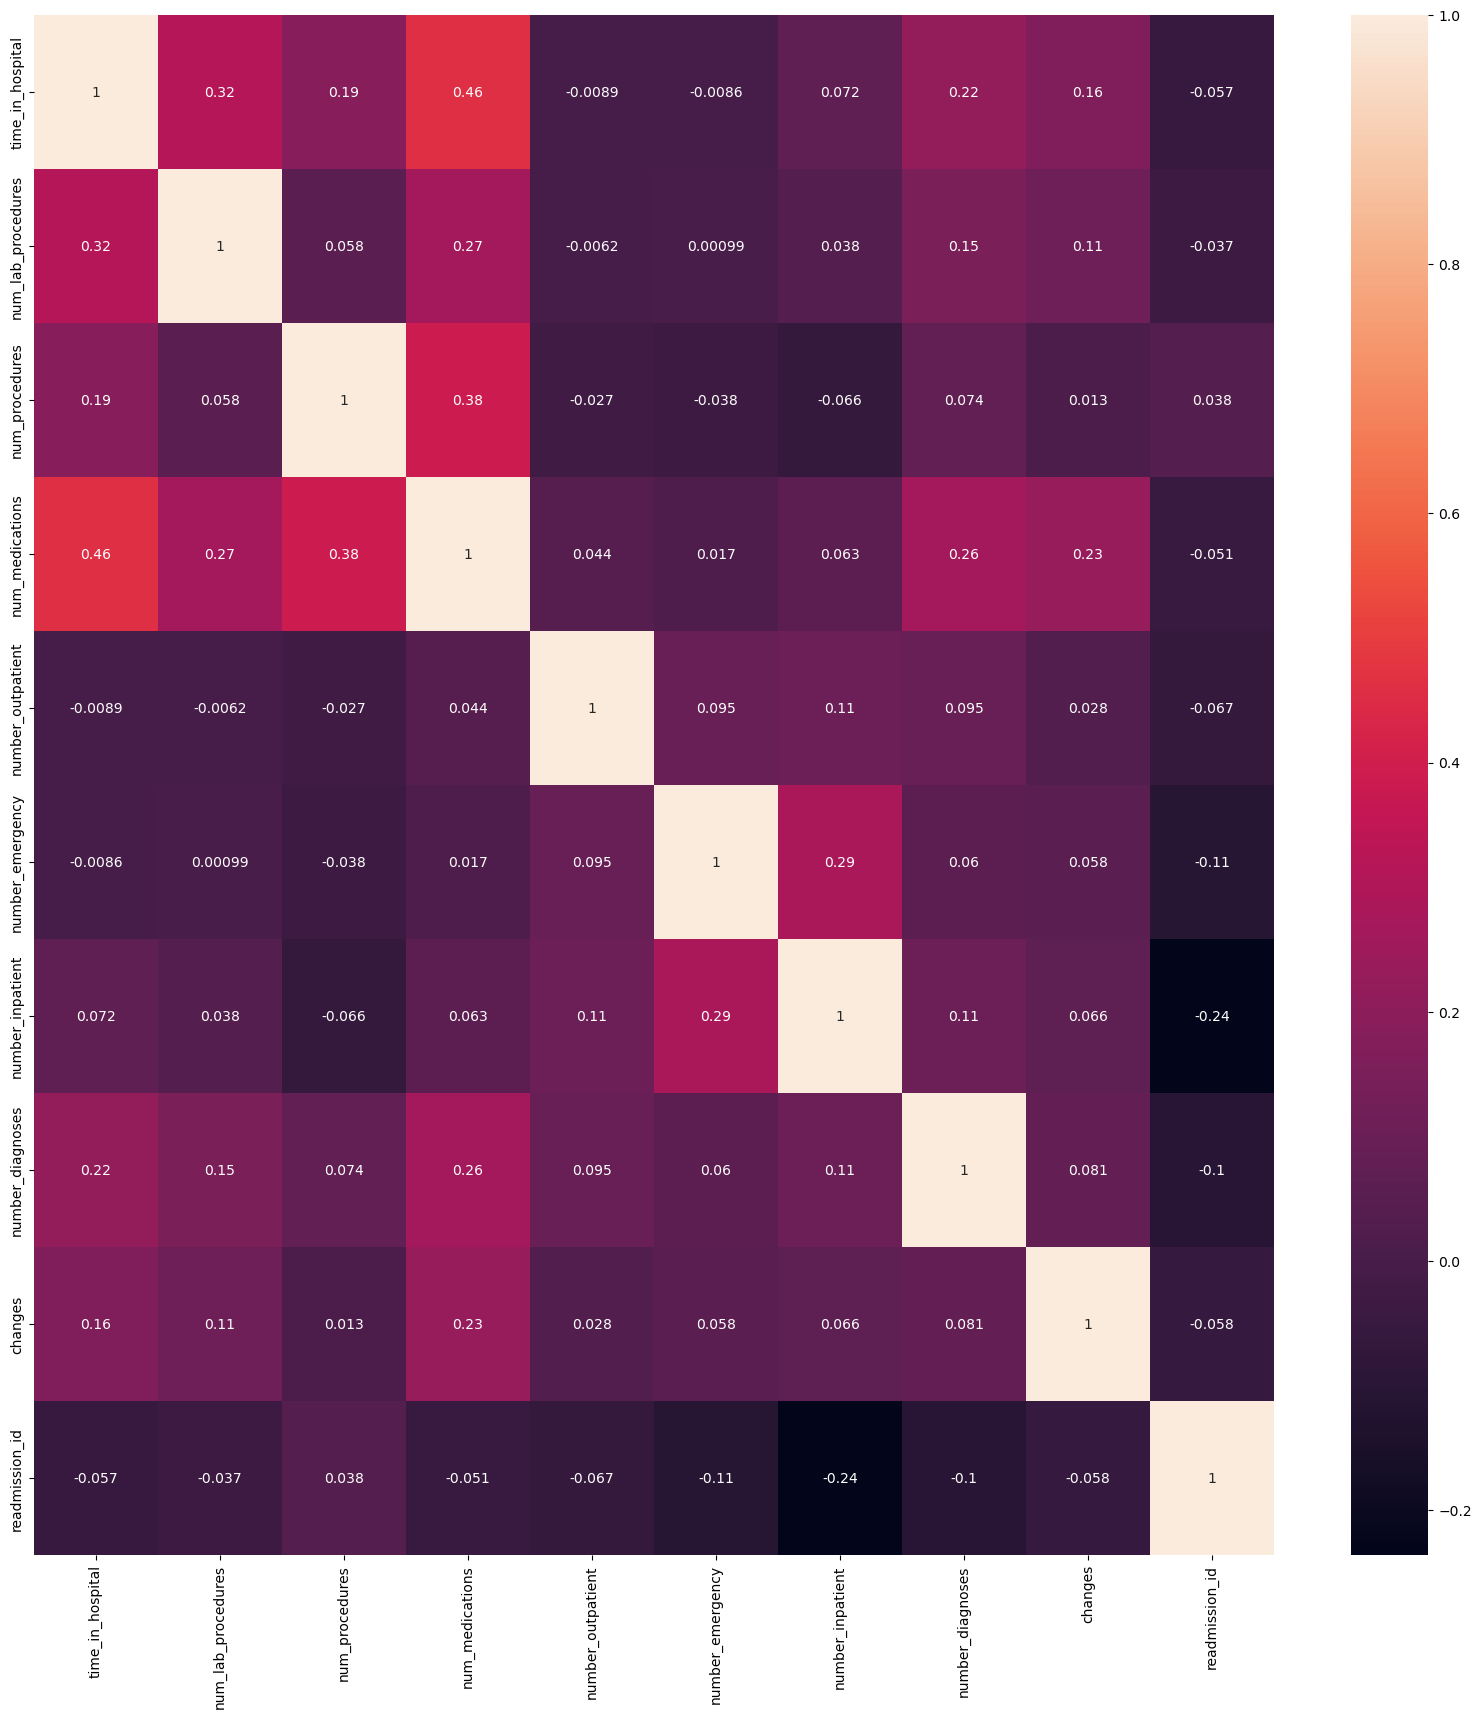

In [564]:
plt.figure(figsize=(20,20))
corr = df.loc[:, ["time_in_hospital","num_lab_procedures","num_procedures","num_medications","number_outpatient","number_emergency","number_inpatient","number_diagnoses","changes", "readmission_id"]].corr()
sns.heatmap(corr,annot=True)

In [565]:
# for col in df.loc[:,'metformin':'diabetesMed']:
#     df_grouped = df.groupby(by=col)['readmission_id'].value_counts(normalize=True).unstack('readmission_id')
#     df_grouped.plot.bar(stacked=True)

<Axes: xlabel='race'>

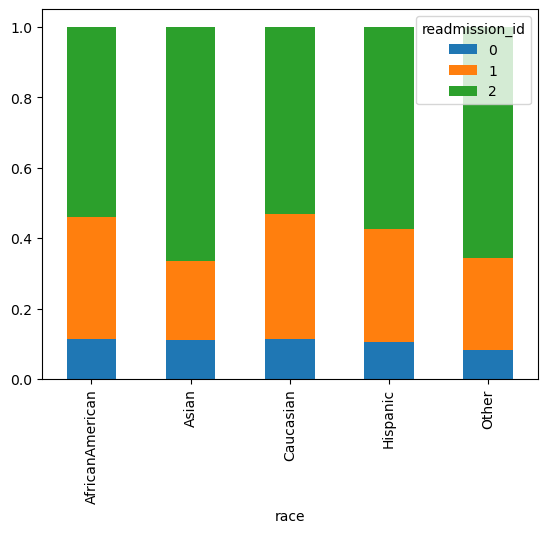

In [566]:
df_grouped = df.groupby(by=['race'])['readmission_id'].value_counts(normalize=True).unstack('readmission_id')
df_grouped.plot.bar(stacked=True)

<Axes: xlabel='gender'>

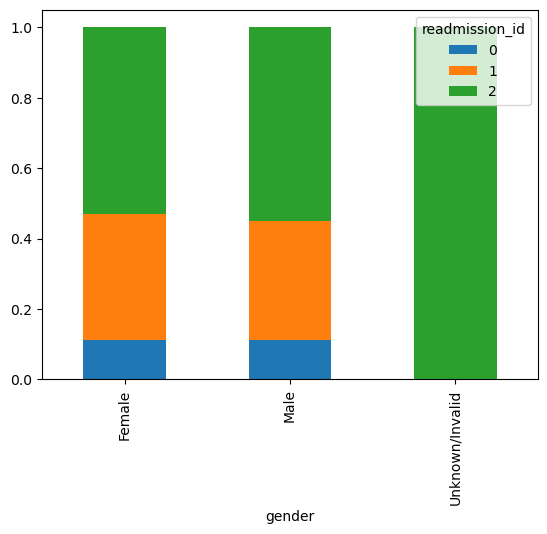

In [567]:
df_grouped = df.groupby(by=['gender'])['readmission_id'].value_counts(normalize=True).unstack('readmission_id')
df_grouped.plot.bar(stacked=True)

<Axes: xlabel='age'>

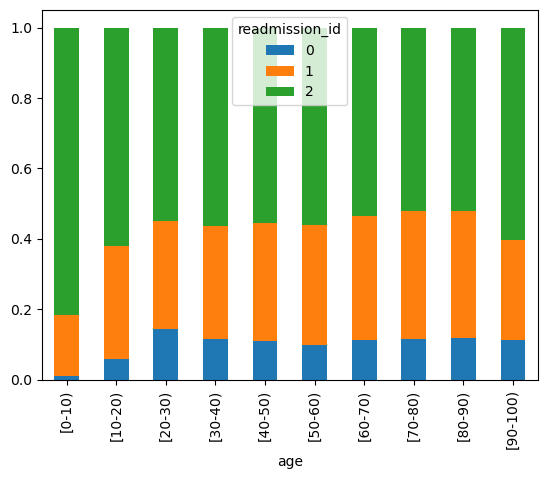

In [568]:
df_grouped = df.groupby(by=['age'])['readmission_id'].value_counts(normalize=True).unstack('readmission_id')
df_grouped.plot.bar(stacked=True)

In [569]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'diabetesMed', 'diag_1_new', 'diag_2_new',
       'diag_3_new', 'changes', 'readmission_id'],
      dtype='object')

In [570]:
test_df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'diabetesMed', 'diag_1_new', 'diag_2_new',
       'diag_3_new', 'changes'],
      dtype='object')

In [571]:
input = df.loc[:, "race":"changes"]
labels = df.loc[:, "readmission_id"]
input.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'diabetesMed', 'diag_1_new', 'diag_2_new',
       'diag_3_new', 'changes'],
      dtype='object')

In [572]:
input_encoded = pd.get_dummies(input, columns=['race', 'gender', 'age', 'diabetesMed',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
       'diag_1_new', 'diag_2_new', 'diag_3_new'])

# input_encoded = pd.get_dummies(input, columns=['race', 'gender', 'age',
#        'medical_specialty', 'max_glu_serum', 'A1Cresult', 'diabetesMed', 'Number_of_Diagnosis',
#        'admission_type_id_new', 'discharge_type_id_new', 'admission_source_id_new'])

print(input_encoded.columns)

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'changes',
       'race_AfricanAmerican',
       ...
       'diag_3_new_8', 'diag_3_new_9', 'diag_3_new_10', 'diag_3_new_11',
       'diag_3_new_12', 'diag_3_new_13', 'diag_3_new_14', 'diag_3_new_16',
       'diag_3_new_17', 'diag_3_new_18'],
      dtype='object', length=134)


In [573]:
test_encoded = pd.get_dummies(test_df, columns=['race', 'gender', 'age', 'diabetesMed',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
       'diag_1_new', 'diag_2_new', 'diag_3_new'])

# test_encoded = pd.get_dummies(test_df, columns=['race', 'gender', 'age',
#        'medical_specialty', 'max_glu_serum', 'A1Cresult', 'diabetesMed', 'Number_of_Diagnosis',
#        'admission_type_id', 'discharge_disposition_id', 'admission_source_id'])

# test_encoded = pd.get_dummies(test_df, columns=['race', 'gender', 'age',
#        'medical_specialty', 'max_glu_serum', 'A1Cresult', 'diabetesMed', 'Number_of_Diagnosis',
#        'admission_type_id_new', 'discharge_type_id_new', 'admission_source_id_new'])


print(test_encoded.columns)

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'changes',
       'race_AfricanAmerican',
       ...
       'diag_3_new_8', 'diag_3_new_9', 'diag_3_new_10', 'diag_3_new_11',
       'diag_3_new_12', 'diag_3_new_13', 'diag_3_new_14', 'diag_3_new_16',
       'diag_3_new_17', 'diag_3_new_18'],
      dtype='object', length=130)


In [574]:
for i in input_encoded.columns:
    if i not in test_encoded.columns:
       test_encoded[i] = 0

for i in test_encoded.columns:
    if i not in input_encoded.columns:
       test_encoded.drop(columns=[i], inplace=True)

input_encoded.sort_index(axis=1, inplace=True)
test_encoded.sort_index(axis=1, inplace=True)

In [575]:
print(input_encoded.columns)
print(test_encoded.columns)

Index(['admission_source_id_1', 'admission_source_id_10',
       'admission_source_id_11', 'admission_source_id_13',
       'admission_source_id_14', 'admission_source_id_17',
       'admission_source_id_2', 'admission_source_id_20',
       'admission_source_id_22', 'admission_source_id_25',
       ...
       'number_diagnoses', 'number_emergency', 'number_inpatient',
       'number_outpatient', 'race_AfricanAmerican', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'time_in_hospital'],
      dtype='object', length=134)
Index(['admission_source_id_1', 'admission_source_id_10',
       'admission_source_id_11', 'admission_source_id_13',
       'admission_source_id_14', 'admission_source_id_17',
       'admission_source_id_2', 'admission_source_id_20',
       'admission_source_id_22', 'admission_source_id_25',
       ...
       'number_diagnoses', 'number_emergency', 'number_inpatient',
       'number_outpatient', 'race_AfricanAmerican', 'race_Asian',
       'race_Ca

In [576]:
scaler = StandardScaler()
input_encoded[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'changes']] = scaler.fit_transform(input_encoded[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'changes']].to_numpy())
test_encoded[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'changes']] = scaler.fit_transform(test_encoded[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'changes']].to_numpy())

In [577]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('transformer', PolynomialFeatures(degree=2, include_bias=False), ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']),
#     ],
#     remainder='passthrough'
# )

# input_encoded = preprocessor.fit_transform(input_encoded)
# test_encoded = preprocessor.transform(test_encoded)

In [578]:
X_train,X_test,Y_train,Y_test = train_test_split(input_encoded, labels, test_size=0.25, random_state=42)

In [579]:
# index_vals = df['readmission_id'].astype('category').cat.codes

# dimensions = []

# cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'changes']

# for i in cols:
#     d = dict(label=i, values=df[i])
#     dimensions.append(d)

# fig = go.Figure(data=go.Splom(
#      dimensions=dimensions,
#      diagonal_visible=False,
#      text=df['readmission_id'],
#      marker=dict(color=index_vals,
#                line_color='white', line_width=0.5)
# ))

# fig.update_layout(
#     title='Readmission id',
#     dragmode='select',
#     width=1300,
#     height=1300,
#     hovermode='closest',
# )

# fig.show()


In [580]:
# lr = LogisticRegression(random_state=42, multi_class="multinomial")
# lr.fit(X_train,Y_train)

# y_pred = lr.predict(X_test)
# print(accuracy_score(y_pred, Y_test))

In [581]:
# nb = GaussianNB()
# nb.fit(X_train,Y_train)

# y_pred = nb.predict(X_test)
# print(accuracy_score(y_pred, Y_test))

In [582]:
# tree = DecisionTreeClassifier(max_depth=20,random_state=42)
# tree.fit(X_train,Y_train)

# y_pred = tree.predict(X_test)
# print(accuracy_score(y_pred, Y_test))

In [583]:
rf = RandomForestClassifier(random_state=42, criterion='gini', max_depth=19, n_estimators=440)
rf.fit(X_train,Y_train)

y_pred = rf.predict(X_test)
print(accuracy_score(y_pred, Y_test))

0.5817283396035712


In [584]:
# gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=4,random_state=42)
# gbc.fit(X_train,Y_train)

# y_pred = gbc.predict(X_test)
# print(accuracy_score(y_pred, Y_test))

In [585]:
test_Y = rf.predict(test_encoded)

df_output = pd.read_csv("./canadian-hospital-re-admittance-challenge/sample_submission.csv")
df_output["readmission_id"] = test_Y
df_output.to_csv("submission.csv", index=False)

In [490]:
# def objective(trial):
#     criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
#     max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
#     n_estimators = trial.suggest_int("n_estimators", 100,500)
#     rf = RandomForestClassifier(criterion =criterion,
#             max_depth=max_depth, 
#             n_estimators=n_estimators
#         )
#     X_train,X_test,Y_train,Y_test = train_test_split(input_encoded, labels, test_size=0.2, random_state=42)
#     rf.fit(X_train,Y_train)
#     y_pred = rf.predict(X_test)
#     score = accuracy_score(y_pred, Y_test)
#     return score

In [491]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=15)

[I 2023-10-17 13:57:27,945] A new study created in memory with name: no-name-a2a9c4f0-4d38-4964-a0ae-d85cbab784cf
[I 2023-10-17 13:57:36,713] Trial 0 finished with value: 0.574957888826502 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 163}. Best is trial 0 with value: 0.574957888826502.
[I 2023-10-17 13:57:41,834] Trial 1 finished with value: 0.5429533969679955 and parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 249}. Best is trial 0 with value: 0.574957888826502.
[I 2023-10-17 13:58:07,974] Trial 2 finished with value: 0.5732032565974172 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 477}. Best is trial 0 with value: 0.574957888826502.
[I 2023-10-17 13:58:18,486] Trial 3 finished with value: 0.5747473329590118 and parameters: {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 177}. Best is trial 0 with value: 0.574957888826502.
[I 2023-10-17 13:58:26,623] Trial 4 finished with value: 0.5496911847276811 and pa

[I 2023-10-17 13:57:27,945] A new study created in memory with name: no-name-a2a9c4f0-4d38-4964-a0ae-d85cbab784cf

[I 2023-10-17 13:57:36,713] Trial 0 finished with value: 0.574957888826502 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 163}. Best is trial 0 with value: 0.574957888826502.

[I 2023-10-17 13:57:41,834] Trial 1 finished with value: 0.5429533969679955 and parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 249}. Best is trial 0 with value: 0.574957888826502.

[I 2023-10-17 13:58:07,974] Trial 2 finished with value: 0.5732032565974172 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 477}. Best is trial 0 with value: 0.574957888826502.

[I 2023-10-17 13:58:18,486] Trial 3 finished with value: 0.5747473329590118 and parameters: {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 177}. Best is trial 0 with value: 0.574957888826502.

[I 2023-10-17 13:58:26,623] Trial 4 finished with value: 0.5496911847276811 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 343}. Best is trial 0 with value: 0.574957888826502.

[I 2023-10-17 13:58:41,483] Trial 5 finished with value: 0.5630263896687254 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 414}. Best is trial 0 with value: 0.574957888826502.

[I 2023-10-17 13:59:17,932] Trial 6 finished with value: 0.5788882650196518 and parameters: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 418}. Best is trial 6 with value: 0.5788882650196518.

[I 2023-10-17 13:59:20,251] Trial 7 finished with value: 0.5298287478944413 and parameters: {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 203}. Best is trial 6 with value: 0.5788882650196518.

[I 2023-10-17 13:59:50,328] Trial 8 finished with value: 0.5781162268388546 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'n_estimators': 353}. Best is trial 6 with value: 0.5788882650196518.

[I 2023-10-17 13:59:54,512] Trial 9 finished with value: 0.5597978663672094 and parameters: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 130}. Best is trial 6 with value: 0.5788882650196518.

[I 2023-10-17 14:00:55,994] Trial 10 finished with value: 0.5823273441886581 and parameters: {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 496}. Best is trial 10 with value: 0.5823273441886581.

[I 2023-10-17 14:02:00,930] Trial 11 finished with value: 0.5820466030320045 and parameters: {'criterion': 'gini', 'max_depth': 31, 'n_estimators': 495}. Best is trial 10 with value: 0.5823273441886581.

[I 2023-10-17 14:03:08,153] Trial 12 finished with value: 0.5814149354295339 and parameters: {'criterion': 'gini', 'max_depth': 32, 'n_estimators': 498}. Best is trial 10 with value: 0.5823273441886581.

[I 2023-10-17 14:04:04,353] Trial 13 finished with value: 0.5818360471645143 and parameters: {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 434}. Best is trial 10 with value: 0.5823273441886581.

[I 2023-10-17 14:04:49,572] Trial 14 finished with value: 0.582678270634475 and parameters: {'criterion': 'gini', 'max_depth': 32, 'n_estimators': 352}. Best is trial 14 with value: 0.582678270634475.